VitalDB's blood pressure signal has noise

In [4]:
from scipy import signal
from sklearn import preprocessing
from scipy.signal import cheby2, freqz, filtfilt
from scipy.signal import decimate

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import os
import csv
import json
from os.path import join

In [2]:
#Functions

def Nan_interpolation(input_sig):
    valid_indx = np.arange(0,input_sig.shape[0])
    
    start_indx = 0
    end_indx = input_sig.shape[0]
    
    if np.isnan(input_sig[0]):
        for value in input_sig:
            if np.isnan(value):
                start_indx += 1
            else:
                start_indx += 1
                break
    if np.isnan(input_sig[-1]):
        for i in range(-1,-input_sig.shape[0],-1):
            if np.isnan(input_sig[i]):
                end_indx -= 1
            else:
                end_indx -= 1
                break
                
    valid_indx = valid_indx[start_indx:end_indx]
    nan_indices = np.where(np.isnan(input_sig[start_indx:end_indx]))
    non_nan_indices = np.arange(len(input_sig[start_indx:end_indx]))[~nan_indices[0]]
    if nan_indices[0].shape[0] !=0:
        input_sig[nan_indices] = np.interp(np.where(nan_indices)[0], non_nan_indices, input_sig[non_nan_indices])
    
    return input_sig, [start_indx, end_indx]

#FIR BPF
def BPFilter(input_sig, lowcut=0.5, highcut=5.0, numtaps = 1001, window = 'hamming'):
    # Define filter parameters
    fs = 125 # Sampling frequency (Hz)
    nyquist = 0.5 * fs # Nyquist frequency
    bands = [lowcut/nyquist, highcut/nyquist]

    # Design the ppg FIR filter
    fir_coeff = signal.firwin(numtaps, bands, window = window, pass_zero = 'bandpass')

    # Apply the filter to the PPG signal
    filtered_sig = signal.lfilter(fir_coeff, 1.0, input_sig)[int((numtaps-1)/2):] #Filter delay
    
    return filtered_sig

def MAFilter(input_sig, window_size):
    window = np.ones(window_size) / window_size
    smoothed_signal = np.convolve(input_sig, window, mode='same')
    return smoothed_signal

def SAI_Algorithm(input_sig):
    # 1. Beat detection
    peaks_indx, _ = signal.find_peaks(input_sig, distance = 50)
    valleys_indx = np.array([], dtype=np.int64)
    valleys_indx = np.append(valleys_indx, [np.argmin(input_sig[peaks_indx[i]: peaks_indx[i + 1]]) + peaks_indx[i] for i in range(len(peaks_indx) - 1)])
    
    # 3. Abnormality criterion
    Ps_c = 180
    Pd_c = 20
    Pm_min_c, Pm_max_c = 30, 200
    f_min_c, f_max_c = 20, 200
    Pp_c = 20
    T = 2 #second
    dPs_c = 20
    dPd_c = 20
    dT_c = 2/3
    
    bp_ft_Ps = input_sig[peaks_indx[2:-1]]
    bp_ft_Pd = input_sig[valleys_indx[2:]]
    bp_ft_Pp = bp_ft_Ps - bp_ft_Pd
    bp_ft_Pm = (bp_ft_Ps + bp_ft_Pd) / 3
    bp_ft_T = (valleys_indx[2:] - valleys_indx[1:-1]) / 100
    bp_ft_f = 60 / bp_ft_T
    
    dPs = np.abs(bp_ft_Ps - input_sig[peaks_indx[1:-2]])
    dPd = np.abs(bp_ft_Pd - input_sig[valleys_indx[1:-1]])
    dT = np.abs(bp_ft_T - (valleys_indx[1:-1] - valleys_indx[:-2]) / 100)
    
    mask = (
        (bp_ft_Ps > Ps_c) |
        (bp_ft_Ps < 80) |
        (bp_ft_Pd < Pd_c) |
        (bp_ft_Pm < Pm_min_c) | (bp_ft_Pm > Pm_max_c) |
        (bp_ft_Pp < Pp_c) |
        (bp_ft_f < f_min_c) | (bp_ft_f > f_max_c) |
        (dPs > dPs_c) |
        (dPd > dPd_c) |
        (dT > dT_c) |
        (bp_ft_T > T)
    )
    
    corrupted_indx = valleys_indx[2:][mask]
            
    return corrupted_indx

def BP_dat_plot(dat, title):
    dist_data_sbp = dat[:, 0]
    dist_data_dbp = dat[:, 1]

    sbp_mean = np.mean(dist_data_sbp)
    dist_data_sbp = dist_data_sbp.astype(int)

    dbp_mean = np.mean(dist_data_dbp)
    dist_data_dbp = dist_data_dbp.astype(int)

    sbp_std = np.std(dat[:, 0])
    dbp_std = np.std(dat[:, 1])

    fig_bp_dist, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

    axs[0].hist(dist_data_sbp, bins=range(min(dist_data_sbp), max(dist_data_sbp)+2))
    axs[0].set_title(title + ' SBP')
    axs[0].axvline(x=sbp_mean, ymin=0, ymax=1, color = 'blue', linestyle = '--')
    axs[0].axvline(x=sbp_mean - sbp_std, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[0].axvline(x=sbp_mean + sbp_std, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[0].set_xlabel('SBP value [mmHg]')
    axs[0].set_ylabel('samples')
    axs[0].text(0.95, 0.95, 'Mean: %0.fmmHg\nStd: %0.fmmHg'%(sbp_mean, sbp_std), transform=axs[0].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    axs[1].hist(dist_data_dbp, bins=range(min(dist_data_dbp), max(dist_data_dbp)+2))
    axs[1].set_title(title + ' DBP')
    axs[1].axvline(x=dbp_mean, ymin=0, ymax=1, color = 'blue', linestyle = '--')
    axs[1].axvline(x=dbp_mean - sbp_std, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[1].axvline(x=dbp_mean + sbp_std, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[1].set_xlabel('DBP value [mmHg]')
    axs[1].set_ylabel('samples')
    axs[1].text(2.17, 0.95, 'Mean: %0.fmmHg\nStd: %0.fmmHg'%(dbp_mean, dbp_std), transform=axs[0].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
  

In [6]:
# Open the CSV file and read the data
folder_path = 'F:\\Lab\\Research\\NIBP_PPG\\Materials\\Dataset\\Ex_3\\NIBP_dataset\\raw\\'
input_file_name = input("Type sub number: ")+'.json'
ppg_csv_sig = []
bp_csv_sig = []

data_keys = ['data_PPG', 'data_BP']

with open(join(folder_path, input_file_name), 'r') as f:
    data = json.load(f)
    


Type sub number: 1


In [16]:
len(data['data_PPG'])
print(data['data_BP'])

[{'SBP': 141, 'DBP': 82}, {'SBP': 134, 'DBP': 73}, {'SBP': 125, 'DBP': 70}, {'SBP': 118, 'DBP': 57}]


Type case number: 05
signal shape:  (1088273,)
Sample start from: 0


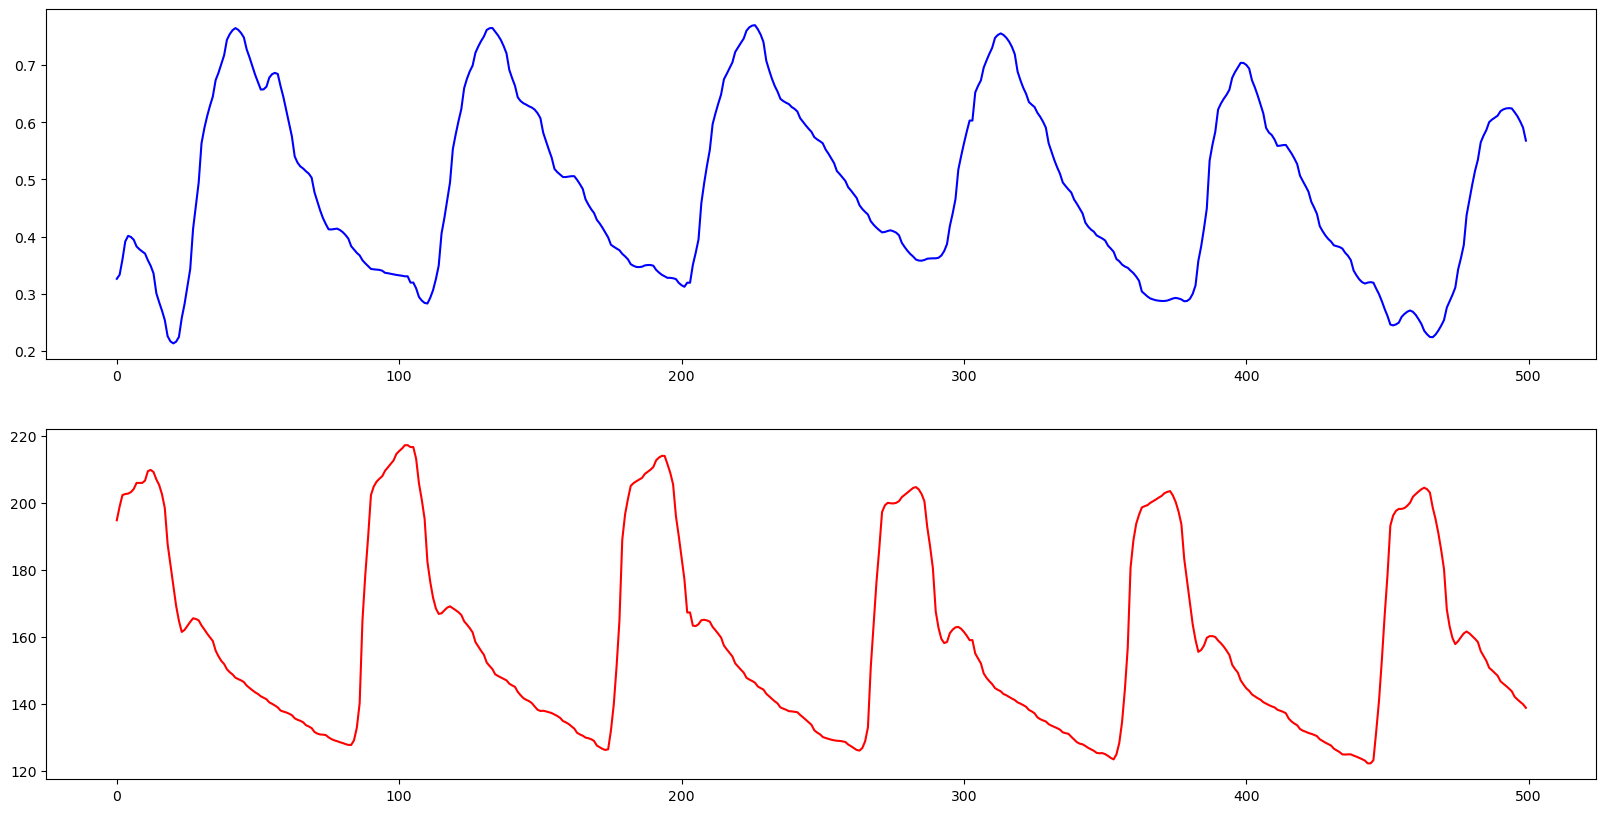

Is it okay? (y or n)y


In [11]:
#모든 신호의 주파수: 100Hz

# Open the CSV file and read the data
folder_path = 'F:\\Lab\\Research\\NIBP_PPG\\Materials\\Dataset\\Ex_3\\NIBP_dataset\\raw\\'
input_file_name = input("Type sub number: ")
input_path = folder_path +input_file_name+'.json'
ppg_csv_sig = []
bp_csv_sig = []

data_keys = ['data_PPG', 'data_BP']

with open(join(input_path, '1.json'), 'r') as f:
    data = json.load(f)
    
# Loop through each CSV file and read its content
for csv_file in csv_files:
    csv_file_path = os.path.join(folder_path, csv_file)
    with open(csv_file_path, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        next(csvreader)
        for row in csvreader:
            ppg_csv_sig.append(row[52])
            bp_csv_sig.append(row[54])
            
# Trun list into numpy array
ppg_raw_sig = np.array([float(element) if element else float('nan') for element in ppg_csv_sig])
bp_raw_sig = np.array([float(element) if element else float('nan') for element in bp_csv_sig])

ppg_raw_sig, ppg_indx = Nan_interpolation(ppg_raw_sig)
bp_raw_sig, bp_indx = Nan_interpolation(bp_raw_sig)

min_indx = 0
max_indx = 0
if bp_indx[0] > ppg_indx[0]:
    min_indx = bp_indx[0]
else:
    min_indx = ppg_indx[0]

if bp_indx[1] < ppg_indx[1]:
    max_indx = bp_indx[1]
else:
    max_indx = ppg_indx[1]
    
ppg_raw_sig = ppg_raw_sig[min_indx:max_indx]
bp_raw_sig = bp_raw_sig[min_indx:max_indx]
print("signal shape: ", ppg_raw_sig.shape)

flag = True
while(flag):
    samp_from = int(input("Sample start from: "))
    samp_to = samp_from + 500
    fig, ax = plt.subplots(2,1,figsize=(20,10))
    ax[0].plot(ppg_raw_sig[samp_from:samp_to], c='b')
    ax[1].plot(bp_raw_sig[samp_from:samp_to], c='r')
    plt.show()
    flg_val = input("Is it okay? (y or n)")
    if flg_val == 'y':
        flag = False
    elif flg_val == 'n':
        samp_from += 500
    else:
        print("Wrong, Type again: ")
        
ppg_raw_sig = ppg_raw_sig[samp_from:]
bp_raw_sig = bp_raw_sig[samp_from:]

In [12]:
sampling_freq = 100
file_name = "case"+input_file_name

#Lag compensation using Cross Correlation function
ppg_fp = ppg_raw_sig[0:250]
ppg_fp = (ppg_fp-np.mean(ppg_fp))/np.std(ppg_fp)
bp_fp = bp_raw_sig[0:250]
bp_fp = (bp_fp-np.mean(bp_fp))/np.std(bp_fp)
correlation = np.correlate(ppg_fp, bp_fp, mode='same')
max_indx = signal.find_peaks(correlation[125:])
ppg_sig_lc = ppg_raw_sig[max_indx[0][0]:]
bp_raw_sig = bp_raw_sig[:-max_indx[0][0]]

#LFP
# Chebyshev LPF - 10Hz - Mo.. 거의 모든 데이터가 10Hz 내로 존재함 근거, An optimal filter for short PPG
numtaps = 1001
ppg_BPF_sig = BPFilter(ppg_sig_lc, numtaps = numtaps, window = 'hamming')
# BP Moving average filter
bp_MAF_sig = MAFilter(bp_raw_sig, 10)[:-(numtaps-1)//2]

#PPG Downsample to 25Hz
ori_rate = sampling_freq
targ_rate = 25
decimation_factor = int(ori_rate / targ_rate)
ppg_sig = decimate(ppg_BPF_sig, decimation_factor, zero_phase=True)

#5초간 윈도우
indx_num_ppg = 5 * 25
num_chunks_ppg = ppg_sig.shape[0] // indx_num_ppg
indx_num_bp = 5 * sampling_freq
num_chunks_bp = bp_MAF_sig.shape[0] // indx_num_bp

ppg_data = ppg_sig[:num_chunks_ppg * indx_num_ppg].reshape(num_chunks_ppg, indx_num_ppg)
bp_data = bp_MAF_sig[:num_chunks_bp * indx_num_bp].reshape(num_chunks_bp, indx_num_bp)

#Auto-correlation - ppg_corrupted_sig
ppg_data_corrupted_indx = np.empty((0,), dtype=int)
for i in range(ppg_data.shape[0]-1):
    auto_correlation_array = np.correlate(ppg_data[i],ppg_data[i],mode='same')
    auto_correlation_array = auto_correlation_array = auto_correlation_array/np.max(auto_correlation_array)
    temp_peaks = signal.find_peaks(auto_correlation_array, height=0.7)
    if temp_peaks[0].shape[0] < 3:
        ppg_data_corrupted_indx = np.append(ppg_data_corrupted_indx, i)

#BP SAI corrupted signal filter
bp_corrupted_indx = SAI_Algorithm(bp_MAF_sig)

bp_data_corrupted_indx = np.empty((0,), dtype = int)
for i in range(bp_data.shape[0]):
    ispeak, _ = signal.find_peaks(bp_data[i], distance = 50)
    if len(ispeak) <= 2:
        bp_data_corrupted_indx = np.append(bp_data_corrupted_indx, i)
        continue

    else:
        for k in range(bp_corrupted_indx.shape[0]):
            if bp_corrupted_indx[k]>500*i and bp_corrupted_indx[k]<500*(i+1):
                bp_data_corrupted_indx = np.append(bp_data_corrupted_indx, i)
                break

corrupted_data_indx = np.concatenate((ppg_data_corrupted_indx, bp_data_corrupted_indx))
corrupted_data_indx = np.unique(corrupted_data_indx)

ppg_data = np.delete(ppg_data, corrupted_data_indx, axis=0)
bp_data = np.delete(bp_data, corrupted_data_indx, axis=0)

#Normalization
for i in range(ppg_data.shape[0]):
    ppg_mean = np.mean(ppg_data[i])
    ppg_std = np.std(ppg_data[i])
    ppg_data[i] = (ppg_data[i] - ppg_mean) / ppg_std

#Calculate mean of blood pressures
bp_data_label = np.empty((0,2))
for i in range(bp_data.shape[0]):
    peaks_temp = signal.find_peaks(bp_data[i], distance = 50)
    valleys_temp = signal.find_peaks(-bp_data[i], distance = 50)
    peaks_mean = np.mean(bp_data[i,peaks_temp[0]])
    valleys_mean = np.mean(bp_data[i, valleys_temp[0]])
    bp_data_label = np.insert(bp_data_label, bp_data_label.shape[0], [peaks_mean, valleys_mean], axis=0)

#처리한 데이터 저장
print('UQ_'+file_name+" successfully processed, ppg data size: ", ppg_data.shape, 'blood pressure size: ', bp_data_label.shape)
down_folder_dir = "F:\\Lab\\Research\\NIBP_PPG\\Materials\\Dataset\\Ex_3\\UQ_dataset\\Preprocessed"
npz_filename = "processed_UQ_"+file_name
np.savez(down_folder_dir+"\\"+npz_filename, x=ppg_data, y=bp_data_label)

UQ_case05 successfully processed, ppg data size:  (1789, 125) blood pressure size:  (1789, 2)
